In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, MaxPooling1D, Dropout, AveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf

2024-12-17 15:42:26.519736: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 15:42:26.551666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 15:42:26.551696: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 15:42:26.551720: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 15:42:26.558716: I tensorflow/core/platform/cpu_feature_g

In [2]:
# 1. Preparación de Datos
data = pd.read_csv("monthly_milk_production.csv")
data.columns = ["Date", "Milk_Production"]
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)

In [3]:
data.head(15)

,Milk_Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
1962-06-01,697
1962-07-01,640
1962-08-01,599
1962-09-01,568


In [4]:
data.describe()

,Milk_Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [5]:
# Escalar datos
data_values = data["Milk_Production"].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_values)

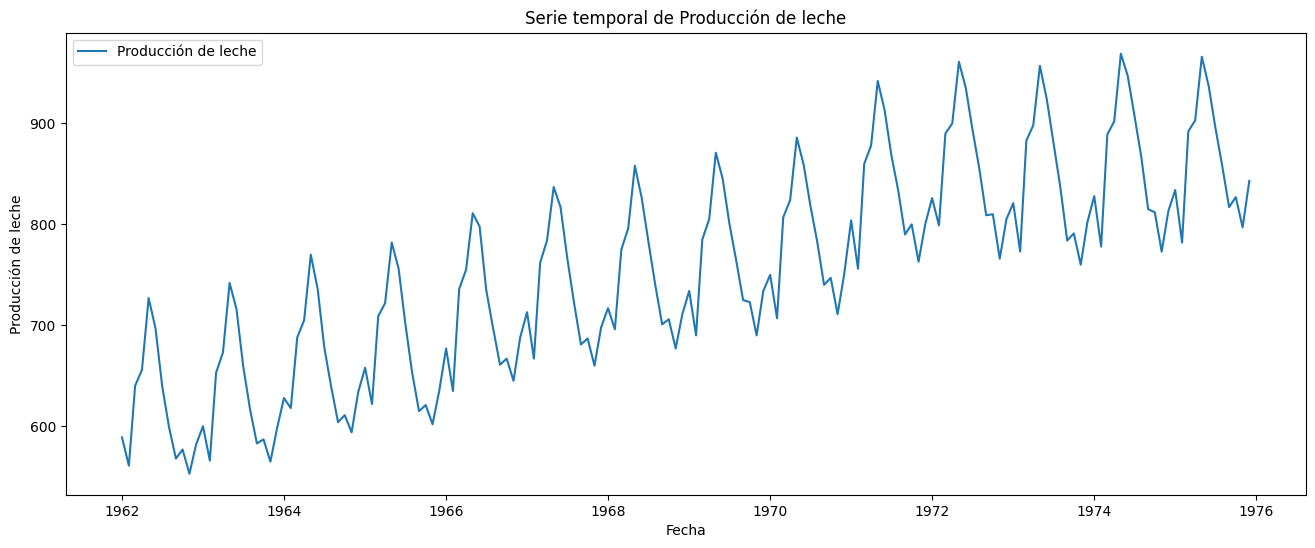

In [6]:
# 2. Visualización de la serie temporal
plt.figure(figsize=(16, 6))
plt.plot(data.index, data["Milk_Production"], label="Producción de leche")
plt.title("Serie temporal de Producción de leche")
plt.xlabel("Fecha")
plt.ylabel("Producción de leche")
plt.legend()
plt.show()

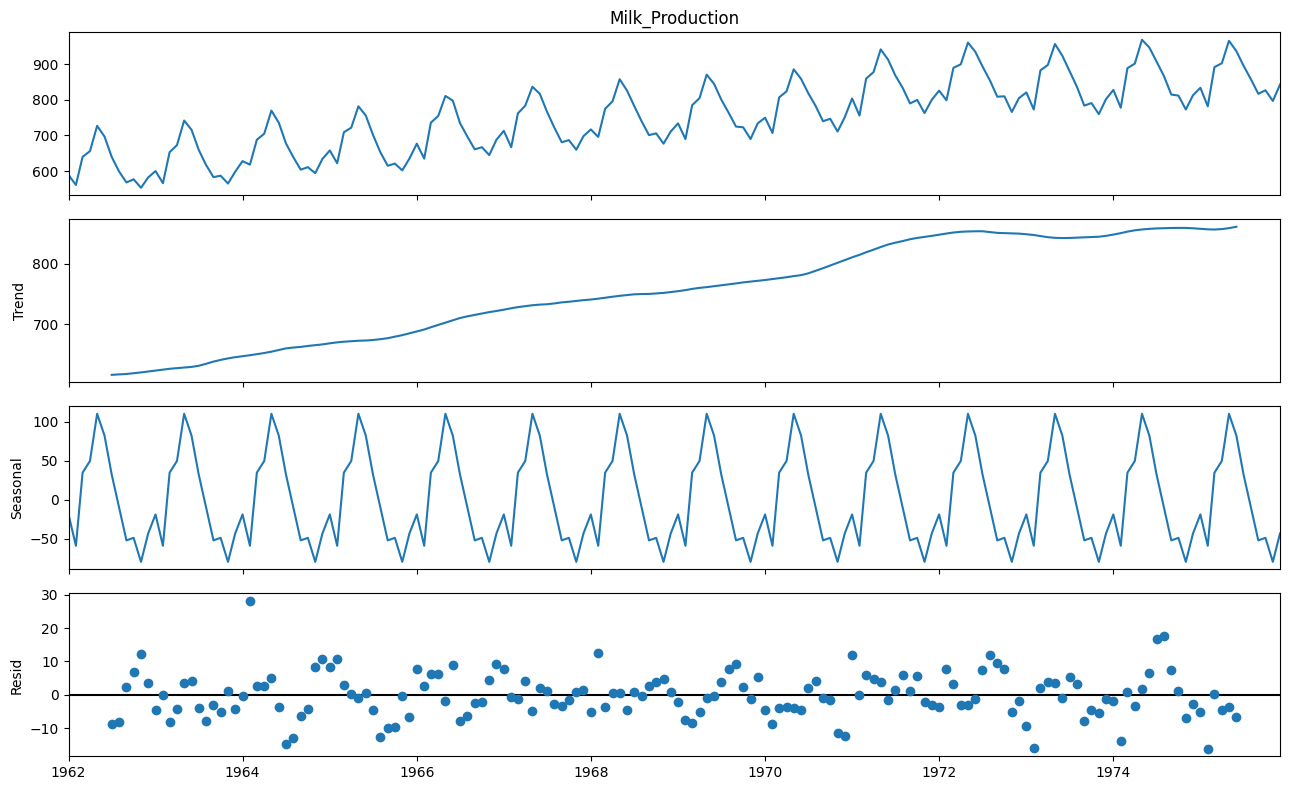

In [7]:
# 3. Análisis de la serie temporal
decomposition = seasonal_decompose(data["Milk_Production"], model="additive", period=12)
fig_decomposition = decomposition.plot()
fig_decomposition.set_size_inches((13, 8))
fig_decomposition.tight_layout()
plt.show()

La imagen muestra la descomposición de la serie temporal de producción de leche en sus componentes:

- La serie original representa la producción total de leche a lo largo del tiempo entre (1962-1975). Se observa una tendencia creciente con un patrón estacional regular (fluctuaciones cíclicas a lo largo de cada año).

- Tendencia. La tendencia indica un incremento gradual y sostenido de la producción de leche durante los años analizados (1962–1975). Esto sugiere un crecimiento en la producción subyacente sin considerar las fluctuaciones estacionales. 

- Estacionalidad. Muestra un patrón cíclico muy claro y constante en el tiempo. El comportamiento estacional indica picos y valles regulares, lo que sugiere un efecto anual que afecta la producción.

- Residuos. Representan las diferencias (ruido) entre la serie original y la combinación de tendencia y estacionalidad. Los residuales no muestran un patrón claro, lo que es una buena señal: implica que la descomposición ha capturado adecuadamente la tendencia y estacionalidad. La mayoría de los puntos residuales están cercanos a cero, indicando un bajo error.


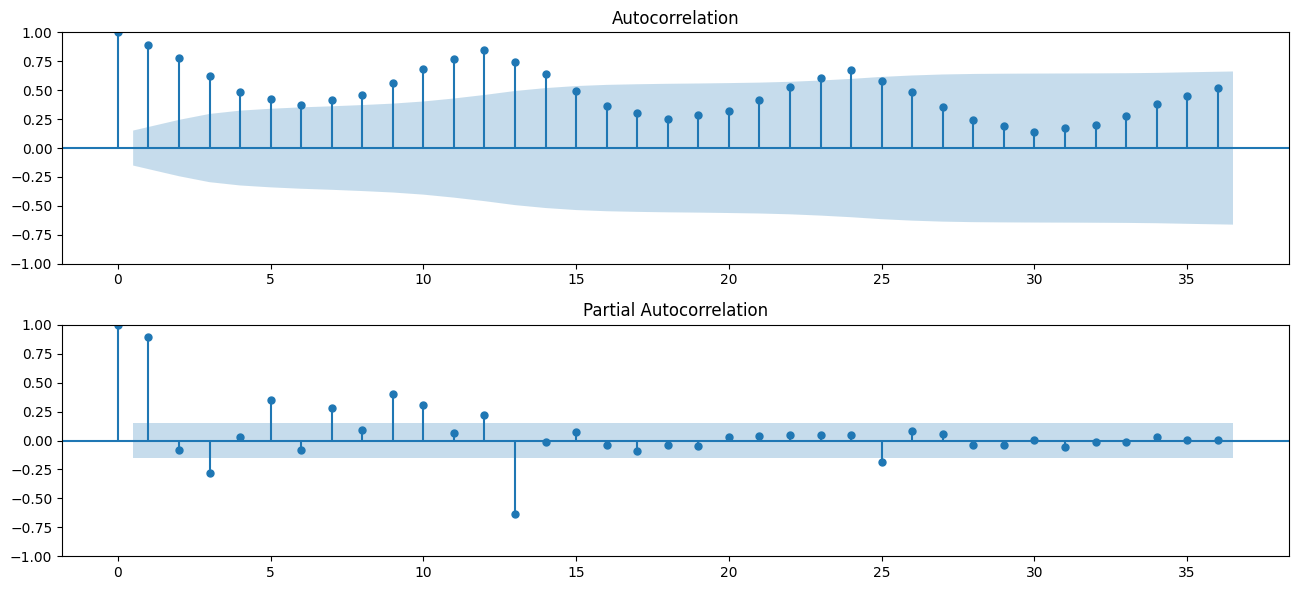

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(13, 6)) 
plot_acf(data, lags=36, alpha=0.05, ax=axes[0])
plot_pacf(data, lags=36, alpha=0.05, ax=axes[1])
plt.tight_layout()
plt.show()

Los valores de la ACF disminuyen a medida que aumenta el lag. Esto sugiere la presencia de un componente autoregresivo (AR) en la serie.
La gran cantidad de valores fuera de las bandas de confianza (líneas azules) indica una alta correlación entre los datos y sus lags. Esto sugiere que la serie podría ser estacionaria.

El valor de la PACF es significativo en los primeros lags y luego decae abruptamente. Esto refuerza la posibilidad de un proceso AR.
El punto en el que el PACF se corta abruptamente podría indicar el orden del proceso AR. En este caso, parece que el primer lag es el más significativo, lo que sugiere un modelo AR(1). También es relevante le lag 13 con un valor elevado.

A continuación ajustamos los datos para ingresarlos al LSTM y dividimos en 3 data sets (train, valid y test).

In [9]:
# 4. Separación de datos para LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 7
X, y = create_sequences(data_scaled, n_steps)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

Con una red simple LSTM definimos los hiperparámetros del modelo

In [10]:
# 5. Modelo LSTM
seed = 123123
np.random.seed(seed)
tf.random.set_seed(seed)

model_lstm = Sequential([
    LSTM(200, activation="relu", return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(100, activation="relu"),
    Dense(1)
])

# hiperparametros
epochs_ = 500
batch_size_ = 16
shuffle_ = False
patience_ = 20
lr_ = 0.0005
loss_ = "mse"

model_lstm.compile(optimizer=Adam(learning_rate=lr_), loss=loss_)
model_lstm.summary()

es = EarlyStopping(monitor="val_loss", patience=patience_, restore_best_weights=True)
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs_, batch_size=batch_size_, shuffle=shuffle_, callbacks=[es])

2024-12-17 15:42:29.642404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 15:42:29.647185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 15:42:29.647303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 15:42:29.649877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 15:42:29.649933: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 282101 (1.08 MB)
Trainable params: 282101 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500


2024-12-17 15:42:32.022866: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4501972b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-17 15:42:32.022905: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-17 15:42:32.027183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 15:42:32.039575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-12-17 15:42:32.110703: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 3s 68ms/step - loss: 0.1731 - val_loss: 0.4009
Epoch 2/500
7/7 [==============================] - 0s 22ms/step - loss: 0.1256 - val_loss: 0.2812
Epoch 3/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0770 - val_loss: 0.1456
Epoch 4/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0366 - val_loss: 0.0449
Epoch 5/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0393 - val_loss: 0.0393
Epoch 6/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0406 - val_loss: 0.0524
Epoch 7/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0379 - val_loss: 0.0624
Epoch 8/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0347 - val_loss: 0.0509
Epoch 9/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0339 - val_loss: 0.0434
Epoch 10/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0344 - val_loss: 0.0443
Epoch 11/500
7/7 [=============

Verificamos que las métricas MSE, MAE y RMSE entregen valores similares para train, valid y test, confirmando un buen entrenamiento y previniendo el sobreajuste.

In [11]:
# Evaluación y métricas en LSTM train
lstm_predictions_train = model_lstm.predict(X_train)
lstm_predictions_rescaled_train = scaler.inverse_transform(lstm_predictions_train)
y_train_rescaled = scaler.inverse_transform(y_train)

mae_milk_lstm_train = mean_absolute_error(y_train_rescaled, lstm_predictions_rescaled_train)
mse_milk_lstm_train = mean_squared_error(y_train_rescaled, lstm_predictions_rescaled_train)

# Evaluación y métricas en LSTM valid
lstm_predictions_val = model_lstm.predict(X_val)
lstm_predictions_rescaled_val = scaler.inverse_transform(lstm_predictions_val)
y_val_rescaled = scaler.inverse_transform(y_val)

mae_milk_lstm_val = mean_absolute_error(y_val_rescaled, lstm_predictions_rescaled_val)
mse_milk_lstm_val = mean_squared_error(y_val_rescaled, lstm_predictions_rescaled_val)

# Evaluación y métricas en LSTM test
lstm_predictions_test = model_lstm.predict(X_test)
lstm_predictions_rescaled_test = scaler.inverse_transform(lstm_predictions_test)
y_test_rescaled = scaler.inverse_transform(y_test)

mae_milk_lstm_test = mean_absolute_error(y_test_rescaled, lstm_predictions_rescaled_test)
mse_milk_lstm_test = mean_squared_error(y_test_rescaled, lstm_predictions_rescaled_test)

df_metrics_lstm = pd.DataFrame([
    ["Mean Absolute Error (MAE)", np.round(mae_milk_lstm_train,2), np.round(mae_milk_lstm_val,2), np.round(mae_milk_lstm_test,2)],
    ["Mean Squared Error (MSE)", np.round(mse_milk_lstm_train,2), np.round(mse_milk_lstm_val,2), np.round(mse_milk_lstm_test,2)],
    ["Root Mean Squared Error (RMSE)", np.round(mse_milk_lstm_train**0.5,2), np.round(mse_milk_lstm_val**0.5,2), np.round(mse_milk_lstm_test**0.5,2)]
    ], 
    columns=['medida', 'train', 'valid', 'test'])
df_metrics_lstm

1/1 [==============================] - 0s 21ms/step


,medida,train,valid,test
0,Mean Absolute Error (MAE),18.94,19.87,23.99
1,Mean Squared Error (MSE),549.17,596.99,859.44
2,Root Mean Squared Error (RMSE),23.43,24.43,29.32


Además, verificamos que la perdida de entrenamiento y validación sea similar.

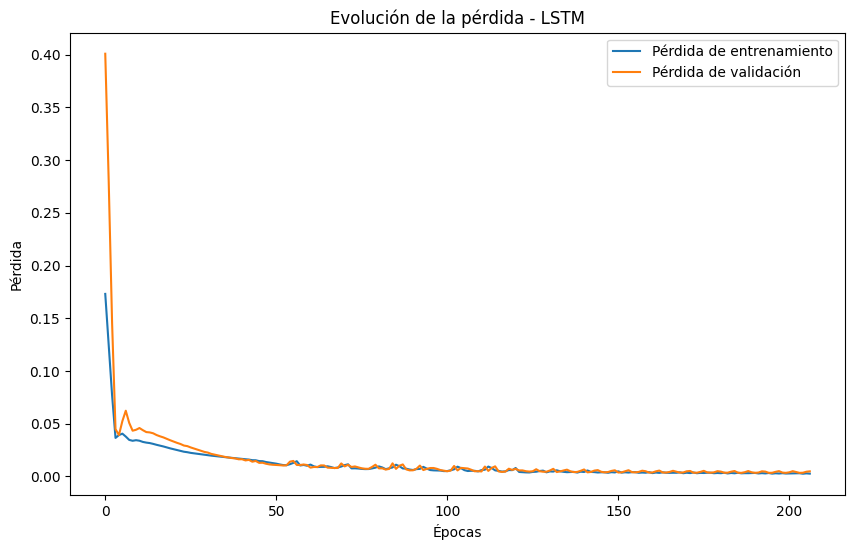

In [13]:
# Visualizar pérdidas del modelo LSTM
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_lstm.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida - LSTM')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Las predicciones de los conjuntos de entrenamiento y validación presentan buen desempeño.

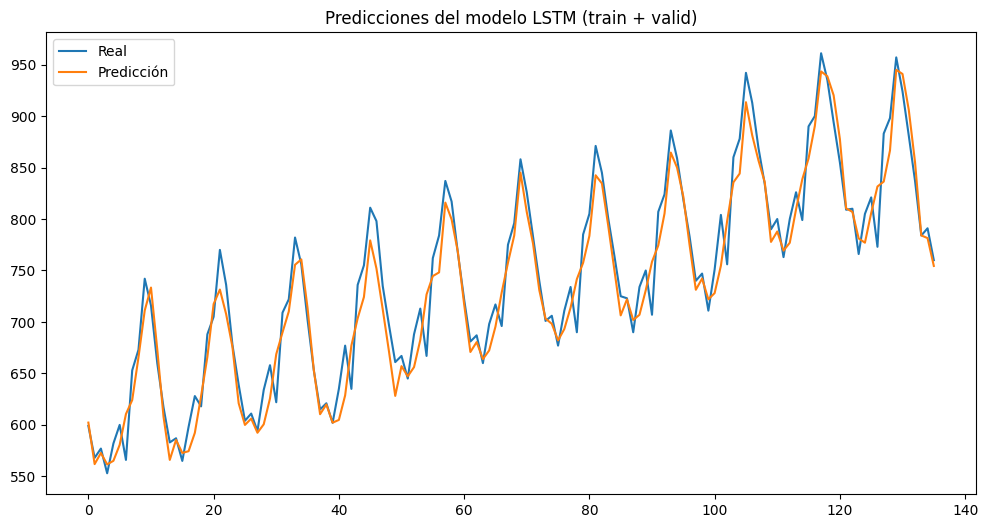

In [12]:
# Visualizar predicciones train
plt.figure(figsize=(12, 6))
plt.plot(list(y_train_rescaled.reshape(-1)) + list(y_val_rescaled.reshape(-1)), label="Real")
plt.plot(list(lstm_predictions_rescaled_train.reshape(-1)) + list(lstm_predictions_rescaled_val.reshape(-1)), label="Predicción")
plt.legend()
plt.title("Predicciones del modelo LSTM (train + valid)")
plt.show()

Al verificar el conjunto de pruebas, también se verifica buen desempeño.

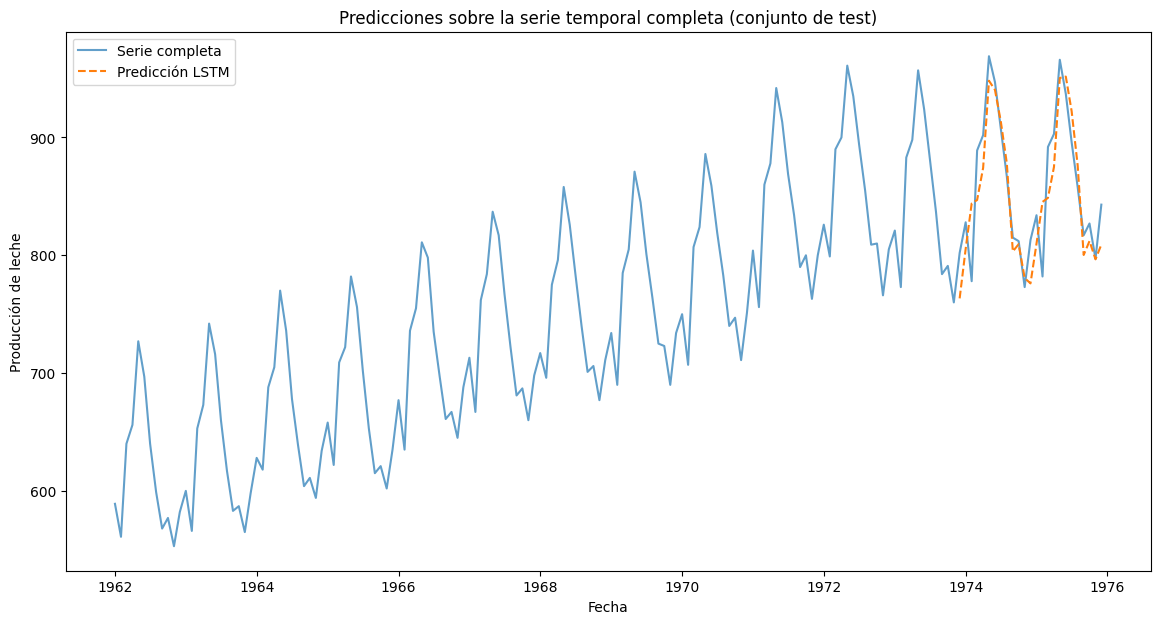

In [14]:
# Visualizar predicciones sobre la serie completa
all_data_index = data.index[-len(y_test_rescaled):]
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Milk_Production"], label="Serie completa", alpha=0.7)
plt.plot(all_data_index, lstm_predictions_rescaled_test, label="Predicción LSTM", linestyle="--")
plt.title("Predicciones sobre la serie temporal completa (conjunto de test)")
plt.xlabel("Fecha")
plt.ylabel("Producción de leche")
plt.legend()
plt.show()

Predicción próximos 3 meses

In [15]:
#Obtener el valor del ultimo dato y darle formato
last_data_lstm = np.expand_dims(X_test[-1,:,:], axis=0)

In [16]:
#prediccion de los siguientes n meses
n_meses = 3
for i in range(n_meses):
    pred_lstm = model_lstm.predict(last_data_lstm)
    last_data_lstm = np.roll(last_data_lstm, -1)
    last_data_lstm[0][-1]=pred_lstm

1/1 [==============================] - 0s 24ms/step


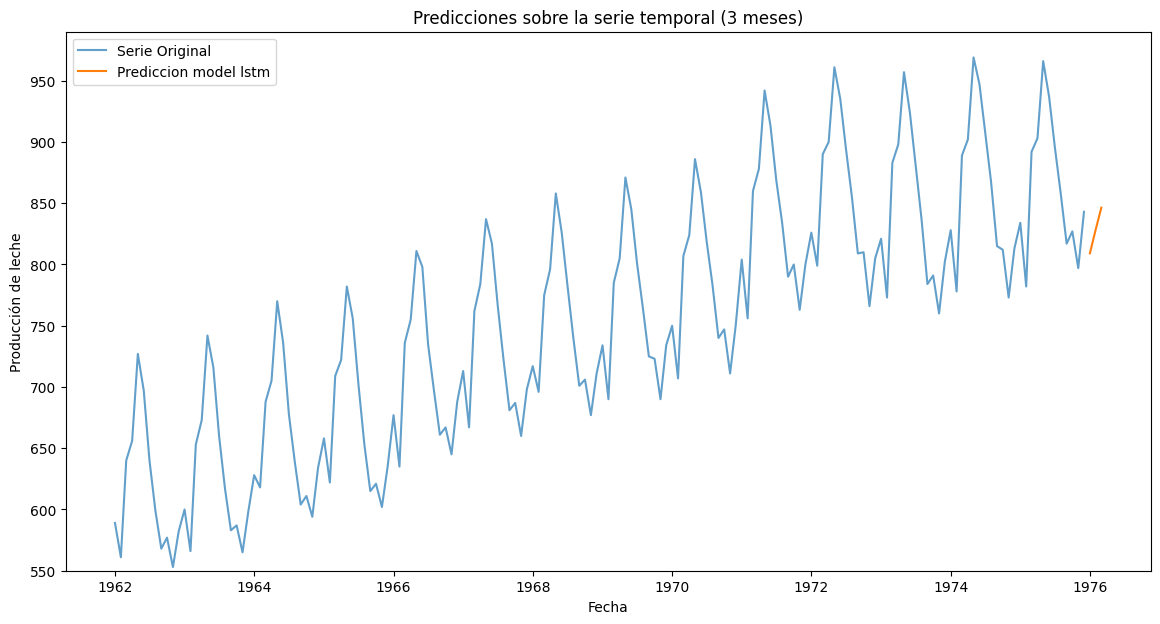

In [17]:
all_data_index_3m = [pd.Timestamp('1976-01-01 00:00:00'), pd.Timestamp('1976-02-01 00:00:00'), pd.Timestamp('1976-03-01 00:00:00')]

plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Milk_Production"].values, label="Serie Original", alpha=0.7)
plt.plot(all_data_index_3m, scaler.inverse_transform(last_data_lstm.reshape(-1,1))[-3:], label='Prediccion model lstm')
plt.title("Predicciones sobre la serie temporal (3 meses)")
plt.xlabel("Fecha")
plt.ylabel("Producción de leche")
plt.ylim(550, 990)
plt.legend()
plt.show()